#Importing The modules and Preprocessing

In [57]:
!wget https://raw.githubusercontent.com/SriniRaghav007/Genomes-and-Gentic-disorder-in-children/main/train.csv?token=AM7YPLQXD3XJL6HXSZMNJX3BWMOCC -O gene_data.csv

--2021-12-06 09:26:13--  https://raw.githubusercontent.com/SriniRaghav007/Genomes-and-Gentic-disorder-in-children/main/train.csv?token=AM7YPLQXD3XJL6HXSZMNJX3BWMOCC
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7617872 (7.3M) [text/plain]
Saving to: ‘gene_data.csv’

gene_data.csv       100%[===================>]   7.26M  --.-KB/s    in 0.1s    

2021-12-06 09:26:14 (75.7 MB/s) - ‘gene_data.csv’ saved [7617872/7617872]



In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import tensorflow as tf
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import KBinsDiscretizer
from matplotlib import pyplot
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import uniform, truncnorm, randint
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [59]:
df=pd.read_csv('gene_data.csv')
df.shape

(22083, 45)

In [60]:
df.describe()

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,Test 1,Test 2,Test 3,Test 4,Test 5,No. of previous abortion,White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
count,20656.000000,22083.000000,16047.000000,16097.000000,19956.0,19931.0,19936.0,19943.0,19913.0,19921.000000,19935.000000,19928.000000,19861.000000,19982.000000,19970.000000,19930.000000
mean,6.974148,4.898871,34.526454,41.972852,0.0,0.0,0.0,1.0,0.0,2.003062,7.486224,0.592483,0.551886,0.536233,0.497747,0.461917
std,4.319475,0.199663,9.852598,13.035501,0.0,0.0,0.0,0.0,0.0,1.411919,2.653393,0.491385,0.497313,0.498698,0.500007,0.498560
min,0.000000,4.092727,18.000000,20.000000,0.0,0.0,0.0,1.0,0.0,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,4.763109,26.000000,31.000000,0.0,0.0,0.0,1.0,0.0,1.000000,5.424703,0.000000,0.000000,0.000000,0.000000,0.000000
50%,7.000000,4.899399,35.000000,42.000000,0.0,0.0,0.0,1.0,0.0,2.000000,7.477132,1.000000,1.000000,1.000000,0.000000,0.000000
75%,11.000000,5.033830,43.000000,53.000000,0.0,0.0,0.0,1.0,0.0,3.000000,9.526152,1.000000,1.000000,1.000000,1.000000,1.000000
max,14.000000,5.609829,51.000000,64.000000,0.0,0.0,0.0,1.0,0.0,4.000000,12.000000,1.000000,1.000000,1.000000,1.000000,1.000000


The perctange of null values of all columns 

In [61]:
(df.isnull().sum()/df.shape[0])*100

Patient Id                                           0.000000
Patient Age                                          6.461984
Genes in mother's side                               0.000000
Inherited from father                                1.385681
Maternal gene                                       12.724720
Paternal gene                                        0.000000
Blood cell count (mcL)                               0.000000
Patient First Name                                   0.000000
Family Name                                         43.884436
Father's name                                        0.000000
Mother's age                                        27.333243
Father's age                                        27.106824
Institute Name                                      23.121858
Location of Institute                                0.000000
Status                                               0.000000
Respiratory Rate (breaths/min)                       9.731468
Heart Ra

Identifying all types of null values and renaming them to nan

In [62]:
df["Birth asphyxia"] = df["Birth asphyxia"].replace("No record",np.NaN)
df["Birth asphyxia"] = df["Birth asphyxia"].replace("Not available",np.NaN)

df["Autopsy shows birth defect (if applicable)"] = df["Autopsy shows birth defect (if applicable)"].replace("None",np.NaN)
df["Autopsy shows birth defect (if applicable)"] = df["Autopsy shows birth defect (if applicable)"].replace("Not applicable",np.NaN)

In [63]:
df["H/O radiation exposure (x-ray)"] = df["H/O radiation exposure (x-ray)"].replace("Not applicable",np.NaN)
df["H/O radiation exposure (x-ray)"] = df["H/O radiation exposure (x-ray)"].replace("-",np.NaN)

df["H/O substance abuse"] = df["H/O substance abuse"].replace("Not applicable",np.NaN)
df["H/O substance abuse"] = df["H/O substance abuse"].replace("-",np.NaN)

Dropping columns based on Domain knowledge and correlation statistics

In [64]:
df.drop(["Patient Id","Patient First Name","Family Name","Father's name","Location of Institute","Institute Name","Place of birth","Parental consent"],inplace=True,axis=1)
#Dropping based on Domain knowledge 
#Test feature columns do not have proper outcome categories
#That is they have only 1 and nan or 0 and nan as value, which is very biased and not appropriate for model construction
#Also there is no indication of what is 1, 0 in for the description of dataset
#Hence the test columns have been dropped
df.drop(["Test 1","Test 2","Test 3","Test 4","Test 5"],inplace=True,axis=1)
#Low correlation
df.drop(["Autopsy shows birth defect (if applicable)","Birth asphyxia","H/O radiation exposure (x-ray)","H/O substance abuse"],inplace=True,axis=1)

In [65]:
len(df.columns)

28

In [66]:
df = df.astype({"Symptom 1": object, "Symptom 2": object,"Symptom 3": object, "Symptom 4": object, "Symptom 5": object})

Creating two categories 1.Categorical columns 2.Numerical columns for statistics

In [67]:
#seprating categorical and numerical label
def split_type(df):
    num_df = []
    cat_df = []
    for i in df.columns:
        if df[i].dtypes =='object':
            cat_df.append(i)
        else:
            num_df.append(i)
    return cat_df,num_df
cat_df,num_df = split_type(df)

In [68]:
cat_df

["Genes in mother's side",
 'Inherited from father',
 'Maternal gene',
 'Paternal gene',
 'Status',
 'Respiratory Rate (breaths/min)',
 'Heart Rate (rates/min',
 'Follow-up',
 'Gender',
 'Folic acid details (peri-conceptional)',
 'H/O serious maternal illness',
 'Assisted conception IVF/ART',
 'History of anomalies in previous pregnancies',
 'Birth defects',
 'Blood test result',
 'Symptom 1',
 'Symptom 2',
 'Symptom 3',
 'Symptom 4',
 'Symptom 5',
 'Genetic Disorder',
 'Disorder Subclass']

In [69]:
num_df

['Patient Age',
 'Blood cell count (mcL)',
 "Mother's age",
 "Father's age",
 'No. of previous abortion',
 'White Blood cell count (thousand per microliter)']

Removing null values from dataset by filling with mode/mean for categorical and numerical data respectively

In [70]:
#removing null values column wise
#filling null values for categorical data if 
for i in cat_df:
  if ((df[i].isnull().sum()/df.shape[0])*100)>15:
    df[i].dropna(inplace=True)
  df[i].fillna(df[i].mode()[0], inplace=True)

Using a threshold of 15% for nul values in a columns above which they are dropped

In [71]:
for i in num_df:
  if ((df[i].isnull().sum()/df.shape[0])*100)>15:
    df[i].dropna(inplace=True)
  df[i].fillna(df[i].mean(), inplace=True)

In [72]:
(df.isnull().sum()/df.shape[0])*100

Patient Age                                         0.0
Genes in mother's side                              0.0
Inherited from father                               0.0
Maternal gene                                       0.0
Paternal gene                                       0.0
Blood cell count (mcL)                              0.0
Mother's age                                        0.0
Father's age                                        0.0
Status                                              0.0
Respiratory Rate (breaths/min)                      0.0
Heart Rate (rates/min                               0.0
Follow-up                                           0.0
Gender                                              0.0
Folic acid details (peri-conceptional)              0.0
H/O serious maternal illness                        0.0
Assisted conception IVF/ART                         0.0
History of anomalies in previous pregnancies        0.0
No. of previous abortion                        

# EDA

In [73]:
df.head()

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,Gender,Folic acid details (peri-conceptional),H/O serious maternal illness,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,2.0,Yes,No,Yes,No,4.760603,34.526454,41.972852,Alive,Normal (30-60),Normal,High,Ambiguous,No,No,No,Yes,2.003062,Singular,9.857562,slightly abnormal,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,4.0,Yes,Yes,No,No,4.910669,34.526454,23.000000,Deceased,Tachypnea,Normal,High,Ambiguous,Yes,Yes,No,Yes,2.003062,Multiple,5.522560,normal,1.0,1.0,1.0,1.0,0.0,Mitochondrial genetic inheritance disorders,Cystic fibrosis
2,6.0,Yes,No,No,No,4.893297,41.000000,22.000000,Alive,Normal (30-60),Tachycardia,Low,Ambiguous,Yes,No,Yes,Yes,4.000000,Singular,7.486224,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,12.0,Yes,No,Yes,No,4.705280,21.000000,41.972852,Deceased,Tachypnea,Normal,High,Male,No,Yes,Yes,Yes,1.000000,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,11.0,Yes,No,Yes,Yes,4.720703,32.000000,41.972852,Alive,Tachypnea,Tachycardia,Low,Male,No,Yes,Yes,No,4.000000,Multiple,4.098210,slightly abnormal,0.0,0.0,0.0,0.0,0.0,Multifactorial genetic inheritance disorders,Cancer


In [74]:
df.corr()

,Patient Age,Blood cell count (mcL),Mother's age,Father's age,No. of previous abortion,White Blood cell count (thousand per microliter),Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5
Patient Age,1.000000,0.010455,-0.006313,-0.008177,-0.006695,-0.007820,0.001997,0.010464,-0.016655,-0.008538,-0.012045
Blood cell count (mcL),0.010455,1.000000,-0.006090,0.002810,-0.005700,-0.000986,0.002585,-0.005347,0.003888,0.004455,0.002684
Mother's age,-0.006313,-0.006090,1.000000,-0.000262,0.006432,0.012690,-0.007901,-0.010749,0.006729,-0.004597,0.007048
Father's age,-0.008177,0.002810,-0.000262,1.000000,0.000451,0.010682,0.001751,-0.003217,0.011167,-0.002107,0.009119
No. of previous abortion,-0.006695,-0.005700,0.006432,0.000451,1.000000,0.003441,-0.006610,0.004591,-0.003647,0.003833,-0.004912
White Blood cell count (thousand per microliter),-0.007820,-0.000986,0.012690,0.010682,0.003441,1.000000,-0.000566,0.007568,0.008170,0.002487,-0.006862
Symptom 1,0.001997,0.002585,-0.007901,0.001751,-0.006610,-0.000566,1.000000,0.012834,0.007435,-0.003506,0.010190
Symptom 2,0.010464,-0.005347,-0.010749,-0.003217,0.004591,0.007568,0.012834,1.000000,0.004895,0.007621,0.002106
Symptom 3,-0.016655,0.003888,0.006729,0.011167,-0.003647,0.008170,0.007435,0.004895,1.000000,0.004290,0.020331
Symptom 4,-0.008538,0.004455,-0.004597,-0.002107,0.003833,0.002487,-0.003506,0.007621,0.004290,1.000000,0.033635


## Data Visualization

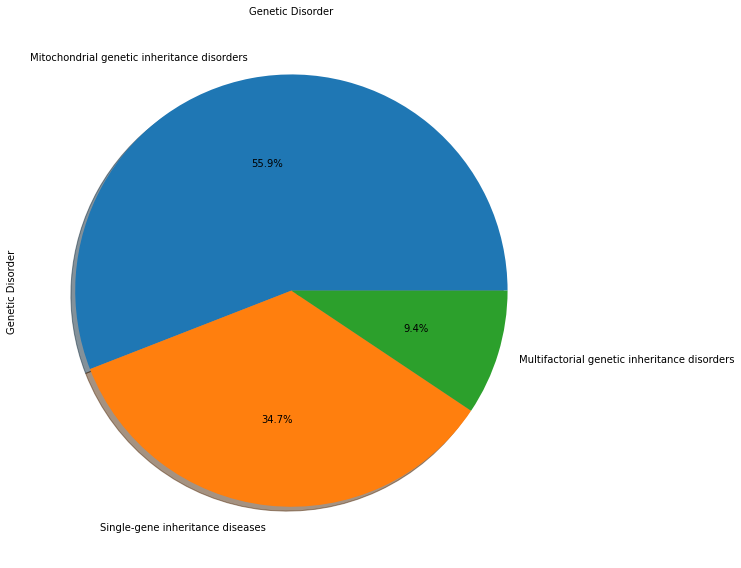

In [75]:
figure = plt.figure(figsize=(18,8))
df["Genetic Disorder"].value_counts().plot.pie(autopct='%1.1f%%',shadow=True)
plt.title('Genetic Disorder', fontsize=10)
plt.tight_layout()
plt.show()

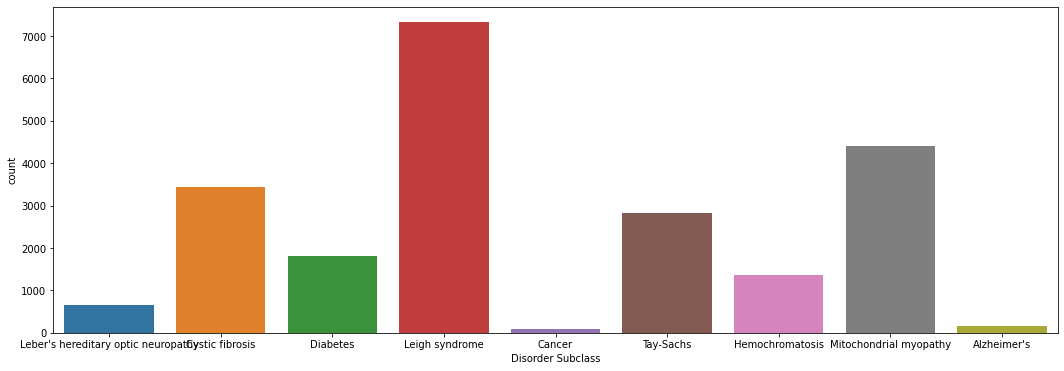

In [76]:
plt.figure(figsize=(18, 6))
sns.countplot(x = 'Disorder Subclass', data = df)

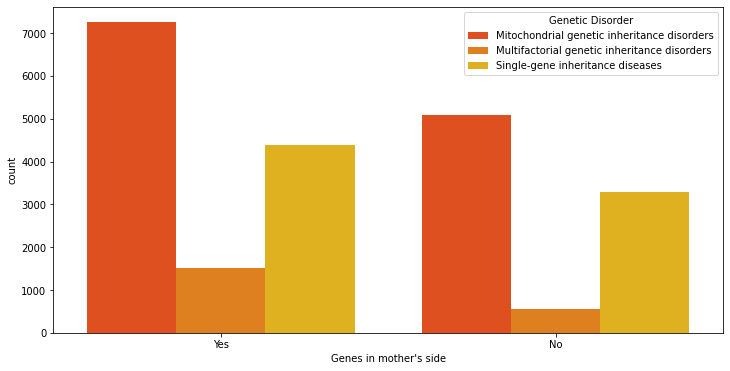

In [77]:
col = ["Genes in mother's side"]
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Genes in mother's side", hue='Genetic Disorder', palette='autumn')

Genes from mother's side have an impact on inheriting the Genetic disorder

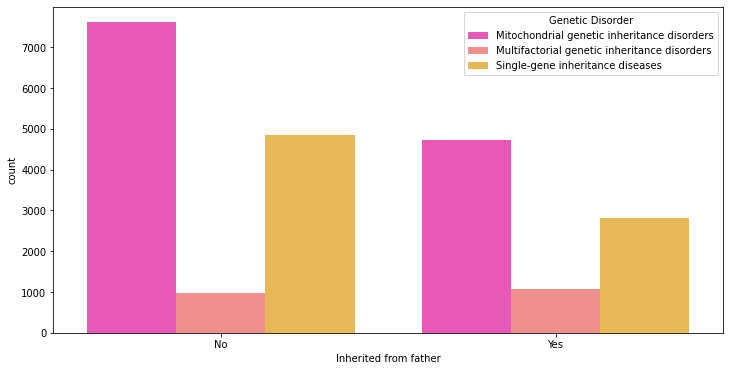

In [78]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Inherited from father", hue='Genetic Disorder', palette='spring')

But genes from father's side did not have much effect

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


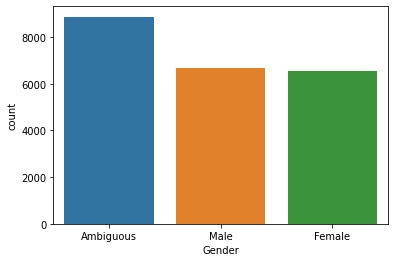

In [79]:
sns.countplot(df['Gender'], data=df)
plt.show()

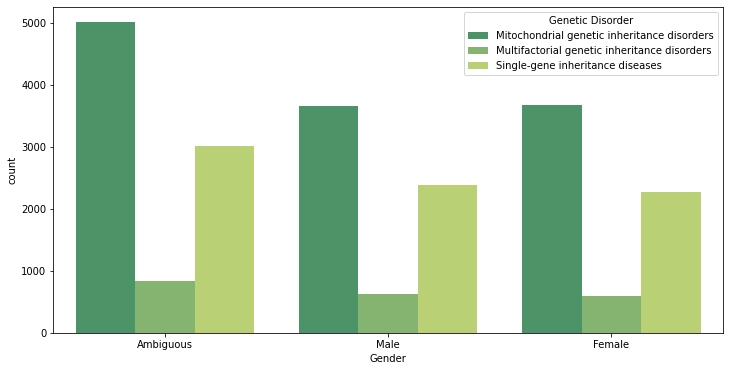

In [80]:
col = ['Gender']
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x='Gender', hue='Genetic Disorder', palette='summer')

No such relation between Gender and Genetic Disorder

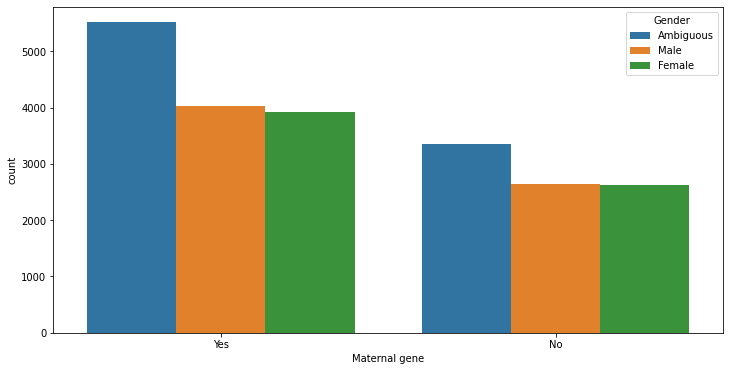

In [81]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Maternal gene", hue='Gender')

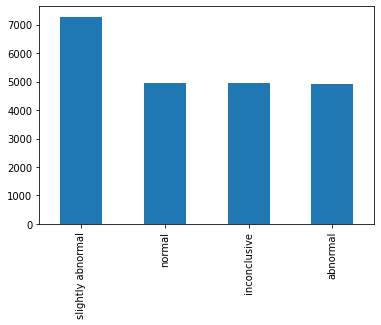

In [82]:
df['Blood test result'].value_counts().plot(kind='bar')

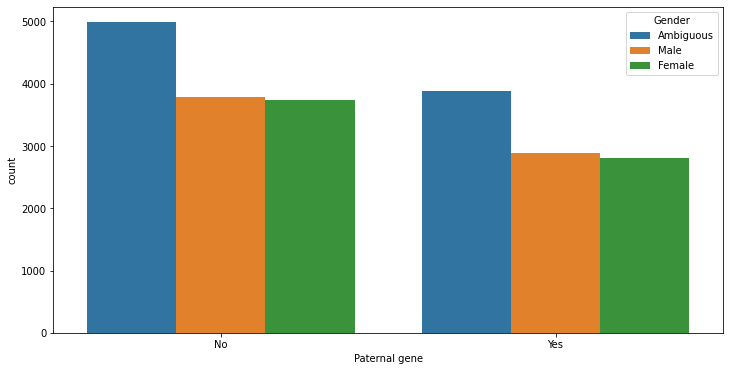

In [83]:
plt.figure(figsize=(12, 6))
sns.countplot(data=df, x="Paternal gene", hue='Gender')

(array([2750., 1396., 2818., 1394., 2801., 2691., 1415., 2666., 1435.,
        2717.]),
 array([ 0. ,  1.4,  2.8,  4.2,  5.6,  7. ,  8.4,  9.8, 11.2, 12.6, 14. ]),
 <a list of 10 Patch objects>)

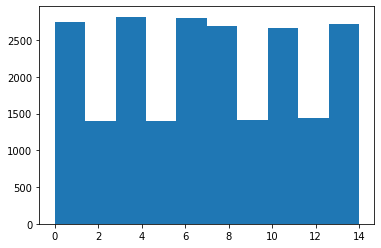

In [84]:
plt.hist(df['Patient Age'])

# Discretization and Label Encoding

In [85]:
num_df=pd.DataFrame(df,columns=['No. of previous abortion','White Blood cell count (thousand per microliter)','Blood cell count (mcL)','Patient Age',"Mother's age","Father's age"])
num_df

,No. of previous abortion,White Blood cell count (thousand per microliter),Blood cell count (mcL),Patient Age,Mother's age,Father's age
0,2.003062,9.857562,4.760603,2.0,34.526454,41.972852
1,2.003062,5.522560,4.910669,4.0,34.526454,23.000000
2,4.000000,7.486224,4.893297,6.0,41.000000,22.000000
3,1.000000,7.919321,4.705280,12.0,21.000000,41.972852
4,4.000000,4.098210,4.720703,11.0,32.000000,41.972852
...,...,...,...,...,...,...
22078,3.000000,6.584811,5.258298,4.0,35.000000,64.000000
22079,2.000000,7.041556,4.974220,8.0,34.526454,56.000000
22080,2.000000,7.715464,5.186470,8.0,35.000000,51.000000
22081,1.000000,8.437670,4.858543,7.0,19.000000,41.972852


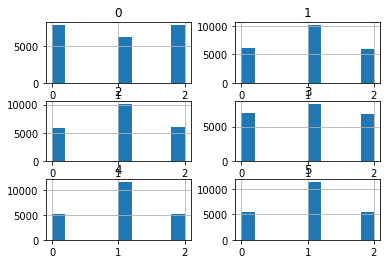

In [86]:
# retrieve just the numeric input values
data = num_df
# perform a k-means discretization transform of the dataset
trans = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='kmeans')
data = trans.fit_transform(data)
# convert the array back to a dataframe
dataset = pd.DataFrame(data)
# histograms of the variables
dataset.hist()
pyplot.show()

In [87]:
dataset.columns=['No. of previous abortion','White Blood cell count (thousand per microliter)','Blood cell count (mcL)','Patient Age',"Mother's age","Father's age"]
dataset

,No. of previous abortion,White Blood cell count (thousand per microliter),Blood cell count (mcL),Patient Age,Mother's age,Father's age
0,1.0,2.0,0.0,0.0,1.0,1.0
1,1.0,0.0,1.0,0.0,1.0,0.0
2,2.0,1.0,1.0,1.0,2.0,0.0
3,0.0,1.0,0.0,2.0,0.0,1.0
4,2.0,0.0,0.0,2.0,1.0,1.0
...,...,...,...,...,...,...
22078,2.0,1.0,2.0,0.0,1.0,2.0
22079,1.0,1.0,1.0,1.0,1.0,2.0
22080,1.0,1.0,2.0,1.0,1.0,2.0
22081,0.0,1.0,1.0,1.0,0.0,1.0


In [88]:
df['No. of previous abortion']=dataset['No. of previous abortion']
df['White Blood cell count (thousand per microliter)']=df['White Blood cell count (thousand per microliter)']
df['Blood cell count (mcL)']=dataset['Blood cell count (mcL)']
df['Patient Age']=dataset['Patient Age']
df["Mother's age"]=dataset["Mother's age"]
df["Father's age"]=dataset["Father's age"]

In [89]:
df.head(15)

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,Gender,Folic acid details (peri-conceptional),H/O serious maternal illness,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,0.0,Yes,No,Yes,No,0.0,1.0,1.0,Alive,Normal (30-60),Normal,High,Ambiguous,No,No,No,Yes,1.0,Singular,9.857562,slightly abnormal,1.0,1.0,1.0,1.0,1.0,Mitochondrial genetic inheritance disorders,Leber's hereditary optic neuropathy
1,0.0,Yes,Yes,No,No,1.0,1.0,0.0,Deceased,Tachypnea,Normal,High,Ambiguous,Yes,Yes,No,Yes,1.0,Multiple,5.522560,normal,1.0,1.0,1.0,1.0,0.0,Mitochondrial genetic inheritance disorders,Cystic fibrosis
2,1.0,Yes,No,No,No,1.0,2.0,0.0,Alive,Normal (30-60),Tachycardia,Low,Ambiguous,Yes,No,Yes,Yes,2.0,Singular,7.486224,normal,0.0,1.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes
3,2.0,Yes,No,Yes,No,0.0,0.0,1.0,Deceased,Tachypnea,Normal,High,Male,No,Yes,Yes,Yes,0.0,Singular,7.919321,inconclusive,0.0,0.0,1.0,0.0,0.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
4,2.0,Yes,No,Yes,Yes,0.0,1.0,1.0,Alive,Tachypnea,Tachycardia,Low,Male,No,Yes,Yes,No,2.0,Multiple,4.098210,slightly abnormal,0.0,0.0,0.0,0.0,0.0,Multifactorial genetic inheritance disorders,Cancer
5,2.0,Yes,No,Yes,No,2.0,1.0,1.0,Deceased,Normal (30-60),Normal,Low,Female,No,No,Yes,No,0.0,Multiple,10.272230,normal,1.0,0.0,0.0,1.0,0.0,Single-gene inheritance diseases,Cystic fibrosis
6,0.0,Yes,No,Yes,Yes,1.0,1.0,2.0,Alive,Normal (30-60),Normal,Low,Male,Yes,Yes,Yes,No,2.0,Multiple,6.825974,normal,0.0,0.0,0.0,0.0,0.0,Single-gene inheritance diseases,Tay-Sachs
7,0.0,No,No,Yes,Yes,1.0,1.0,1.0,Alive,Tachypnea,Normal,Low,Ambiguous,Yes,Yes,No,Yes,0.0,Singular,9.836352,inconclusive,0.0,0.0,1.0,0.0,0.0,Single-gene inheritance diseases,Tay-Sachs
8,2.0,No,No,Yes,No,2.0,2.0,1.0,Alive,Tachypnea,Tachycardia,Low,Male,Yes,Yes,No,Yes,0.0,Multiple,6.669552,slightly abnormal,1.0,1.0,1.0,0.0,1.0,Mitochondrial genetic inheritance disorders,Leigh syndrome
9,0.0,No,Yes,Yes,Yes,0.0,2.0,1.0,Alive,Tachypnea,Tachycardia,Low,Male,Yes,No,Yes,Yes,0.0,Multiple,6.397702,abnormal,0.0,0.0,1.0,1.0,1.0,Multifactorial genetic inheritance disorders,Diabetes


In [90]:
#Label encoder,(ranked approach)
def leb(df):
    from sklearn.preprocessing import LabelEncoder
    label = LabelEncoder()
    for i in df.columns:
        if df[i].dtypes == 'object':
            df[i] = label.fit_transform(df[i])
    return df
df = leb(df)

In [91]:
df

,Patient Age,Genes in mother's side,Inherited from father,Maternal gene,Paternal gene,Blood cell count (mcL),Mother's age,Father's age,Status,Respiratory Rate (breaths/min),Heart Rate (rates/min,Follow-up,Gender,Folic acid details (peri-conceptional),H/O serious maternal illness,Assisted conception IVF/ART,History of anomalies in previous pregnancies,No. of previous abortion,Birth defects,White Blood cell count (thousand per microliter),Blood test result,Symptom 1,Symptom 2,Symptom 3,Symptom 4,Symptom 5,Genetic Disorder,Disorder Subclass
0,0.0,1,0,1,0,0.0,1.0,1.0,0,0,0,0,0,0,0,0,1,1.0,1,9.857562,3,1.0,1.0,1.0,1.0,1.0,0,5
1,0.0,1,1,0,0,1.0,1.0,0.0,1,1,0,0,0,1,1,0,1,1.0,0,5.522560,2,1.0,1.0,1.0,1.0,0.0,0,2
2,1.0,1,0,0,0,1.0,2.0,0.0,0,0,1,1,0,1,0,1,1,2.0,1,7.486224,2,0.0,1.0,1.0,1.0,1.0,1,3
3,2.0,1,0,1,0,0.0,0.0,1.0,1,1,0,0,2,0,1,1,1,0.0,1,7.919321,1,0.0,0.0,1.0,0.0,0.0,0,6
4,2.0,1,0,1,1,0.0,1.0,1.0,0,1,1,1,2,0,1,1,0,2.0,0,4.098210,3,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22078,0.0,1,1,1,0,2.0,1.0,2.0,1,0,1,0,1,1,0,1,0,2.0,0,6.584811,1,0.0,0.0,1.0,0.0,0.0,0,6
22079,1.0,0,1,0,1,1.0,1.0,2.0,0,0,0,0,0,1,1,1,0,1.0,0,7.041556,1,1.0,1.0,1.0,1.0,0.0,1,3
22080,1.0,1,0,1,0,2.0,1.0,2.0,1,1,0,0,2,0,0,0,0,1.0,1,7.715464,2,0.0,0.0,0.0,1.0,0.0,0,7
22081,1.0,1,0,1,1,1.0,0.0,1.0,0,1,1,0,2,1,1,1,0,0.0,0,8.437670,0,1.0,1.0,1.0,0.0,0.0,0,6


## PCA

In [92]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

#Split train-test data
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.15)

In [93]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
X_train_pca = scaler.transform(X_train)
X_test_pca = scaler.transform(X_test)

In [94]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.80)

In [95]:
pca.fit(X_train_pca)

PCA(n_components=0.8)

In [96]:
X_train = pca.transform(X_train_pca)
X_test = pca.transform(X_test_pca)

In [97]:
print(X_train)

[[ 0.16711409  0.74999843 -1.06387963 ... -0.29665356 -0.15994906
  -1.43133294]
 [-0.05409417  1.12779738 -0.64137023 ...  0.18210288  0.76477337
   0.26687655]
 [-0.31510369  0.27882796  0.00757384 ...  0.74595897 -1.75358517
   0.37470982]
 ...
 [ 0.6806545  -0.13752655 -0.50413345 ... -1.07573869  1.81386763
   0.35676655]
 [-0.03765485  0.17040821 -1.1699141  ... -1.67379889 -0.0537022
  -0.23921629]
 [-0.13669806 -0.4091552  -0.62301636 ...  0.00310394  0.13905176
  -0.0895426 ]]


In [98]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy',random_state=100)
classifier.fit(X_train_pca, y_train)

RandomForestClassifier(criterion='entropy', random_state=100)

In [99]:
y_pred = classifier.predict(X_test_pca)

In [100]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  0   0   0  19   0   2   2   0   0]
 [  0  11   0   2   0   0   0   0   0]
 [  0   0 452   0   2   3  40   1  44]
 [  0   0   0 262   0   2  18   0   0]
 [  0   0   5   0  40   0   4  10 110]
 [  0   0   1   1   0  56  46   0   0]
 [  0   2  51  27   3   9 754 199  48]
 [  0   0   0   0   0   1 439 214   0]
 [  0   0  44   0  30   0  25  17 317]]


0.6356776335647449

# SMOTE
## BALANCING THE DATASET

In [101]:
print("Before oversampling: ",Counter(y_train))

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train_pca, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

Before oversampling:  Counter({6: 6235, 7: 3751, 2: 2906, 8: 2400, 3: 1535, 4: 1186, 5: 544, 0: 129, 1: 84})
After oversampling:  Counter({7: 6235, 6: 6235, 2: 6235, 3: 6235, 8: 6235, 4: 6235, 5: 6235, 1: 6235, 0: 6235})


#Models for predicting Genetic Disorder 

##CART

In [105]:

# Function to perform training with giniIndex.
def train_using_gini(X_train, X_test, y_train):

	# Creating the classifier object
	clf_gini = DecisionTreeClassifier(criterion = "gini",
			random_state = 30,max_depth=10, min_samples_leaf=12)

	# Performing training
	clf_gini.fit(X_train, y_train)
	return clf_gini
	
# Function to perform training with entropy.
def tarin_using_entropy(X_train, X_test, y_train):

	# Decision tree with entropy
	clf_entropy = DecisionTreeClassifier(
			criterion = "entropy", random_state = 30,
			max_depth = 10, min_samples_leaf = 12)

	# Performing training
	clf_entropy.fit(X_train, y_train)
	return clf_entropy


# Function to make predictions
def prediction(X_test, clf_object):

	# Predicton on test with giniIndex
	y_pred = clf_object.predict(X_test)
	print("Predicted values:")
	print(y_pred)
	return y_pred
	
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
	
	print("Confusion Matrix: ",
		confusion_matrix(y_test, y_pred))
	
	print ("Accuracy : ",
	accuracy_score(y_test,y_pred)*100)

# Driver code
def main():
	
	# Building Phase
	#data = importdata()
	#X, Y, X_train, X_test, y_train, y_test = splitdataset(data)
	clf_gini = train_using_gini(X_train_SMOTE, X_test_pca, y_train_SMOTE)
	clf_entropy = tarin_using_entropy(X_train_SMOTE, X_test_pca, y_train_SMOTE)
	
	# Operational Phase
	print("Results Using Gini Index:")
	
	# Prediction using gini
	y_pred_gini = prediction(X_test_pca, clf_gini)
	cal_accuracy(y_test, y_pred_gini)
	
	print("Results Using Entropy:")
	# Prediction using entropy
	y_pred_entropy = prediction(X_test_pca, clf_entropy)
	cal_accuracy(y_test, y_pred_entropy)
	
	
# Calling main function
if __name__=="__main__":
	main()

Results Using Gini Index:
Predicted values:
[6 7 3 ... 6 7 5]
Confusion Matrix:  [[  8   0   0  11   0   2   2   0   0]
 [  0  12   0   1   0   0   0   0   0]
 [  0   0 446   0   4   7  31   9  45]
 [ 41   3   1 217   0   7  11   2   0]
 [  0   0   3   0  76   0   8   6  76]
 [  0   0   0   1   0  75  25   3   0]
 [  5   2  57  22  18  27 604 322  36]
 [  0   0   2   0   0   4 314 331   3]
 [  0   0  46   0 108   0  17  23 239]]
Accuracy :  60.6097192876547
Results Using Entropy:
Predicted values:
[6 7 3 ... 6 6 5]
Confusion Matrix:  [[  7   0   0  12   0   2   2   0   0]
 [  0  12   0   1   0   0   0   0   0]
 [  0   0 447   0   2   7  33   3  50]
 [ 39   1   2 220   0   7   9   3   1]
 [  0   0   3   0  77   0   6   7  76]
 [  0   0   1   0   0  77  25   1   0]
 [  3   2  55  24  18  28 579 345  39]
 [  0   0   2   0   2   4 317 324   5]
 [  0   0  53   0  94   0  15  25 246]]
Accuracy :  60.03622094778147


## Naive Bayes Classifier

In [108]:
# training the model on training set

gnb = GaussianNB()
gnb.fit(X_train_SMOTE, y_train_SMOTE)
 
# making predictions on the testing set
y_pred = gnb.predict(X_test_pca)
 
# comparing actual response values (y_test) with predicted response values (y_pred)

print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 51.10172049501962


In [109]:
pipe = Pipeline(steps=[
                    ('pca', PCA()),
                    ('estimator', GaussianNB()),
                    ])
    
parameters = {'estimator__var_smoothing': [1e-11, 1e-10, 1e-9]}
Bayes = RandomizedSearchCV(pipe, parameters, scoring='accuracy', cv=10).fit(X_train_SMOTE, y_train_SMOTE)
print(Bayes.best_estimator_)
print('best score:')
print(Bayes.best_score_)
predictions = Bayes.best_estimator_.predict(X_test_pca)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


Pipeline(steps=[('pca', PCA()), ('estimator', GaussianNB(var_smoothing=1e-11))])
best score:
0.699065617722443


In [110]:
cm = confusion_matrix(y_test, predictions)
print(cm)

[[ 12   0   0   7   0   1   3   0   0]
 [  0   7   0   0   4   0   0   0   2]
 [  3   0 436  15   1   9  23   7  48]
 [ 37   0  32 161   0  13  34   1   4]
 [  0   7   2   0  82   0   0  12  66]
 [  9   0   0  10   0  72  12   1   0]
 [  5   5  51  44  17  31 342 562  36]
 [  0   3   0   3   0   4 123 521   0]
 [  0   2  26   1 121   0   4  34 245]]


In [111]:
print("On tuning")
accuracy_score(y_test, predictions)

On tuning


0.5668578327799577

## KNN

In [112]:
#Create KNN Classifier
knn = KNeighborsClassifier()

#Train the model using the training sets
knn.fit(X_train_SMOTE, y_train_SMOTE)

#Predict the response for test dataset
y_pred = knn.predict(X_test_pca)

In [113]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.3374584968306671


In [114]:
print("Confusion Matrix: ",
		confusion_matrix(y_test, y_pred))

Confusion Matrix:  [[  5   0   3   7   0   7   1   0   0]
 [  0   7   0   0   2   0   1   2   1]
 [ 49   2 228 137  31  27  11  11  46]
 [ 46   0  50 108   5  47  13   5   8]
 [  0  16   5   5  71   1   6   9  56]
 [ 12   0   6  22   0  58   2   3   1]
 [ 26  26  87 142  58 109 231 347  67]
 [  7  31  25  50  53  34 173 250  31]
 [  3  15  46  12 151   3  20  23 160]]


In [115]:
# TUNING
# TUNING
from sklearn.model_selection import GridSearchCV
#List Hyperparameters that we want to tune.
leaf_size = list(range(1,50))
n_neighbors = list(range(1,30))
p=[1,2]
#Convert to dictionary
hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
#Create new KNN object
knn_2 = KNeighborsClassifier()
#Use GridSearch
clf = RandomizedSearchCV(knn_2, hyperparameters, cv=10)
#Fit the model
best_model = clf.fit(X_train_SMOTE,y_train_SMOTE)
#Print The value of best Hyperparameters
print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 35
Best p: 2
Best n_neighbors: 2


In [116]:
# KNN ON TUNING
from sklearn.neighbors import KNeighborsClassifier

#Create KNN Classifier
knn = KNeighborsClassifier(leaf_size=14, p= 1, n_neighbors= 3)

#Train the model using the training sets
knn.fit(X_train_SMOTE, y_train_SMOTE)

#Predict the response for test dataset
y_pred = knn.predict(X_test_pca)

In [117]:
print("Confusion Matrix: ",
		confusion_matrix(y_test, y_pred))

Confusion Matrix:  [[  3   0   5  11   0   3   1   0   0]
 [  0   4   0   0   2   0   3   2   2]
 [ 14   0 305  75  22  16  51   9  50]
 [ 18   0  62 131   4  21  34  10   2]
 [  0   6  18   2  57   0  12   7  67]
 [  3   0  15  17   0  44  17   7   1]
 [  4   6 116  81  34  58 434 304  56]
 [  3   5  41  21  27   9 309 221  18]
 [  0   1  73  11 113   3  49  19 164]]


In [118]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.4114095985511621


##Random Forest Classifier

In [102]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy',random_state=100)
classifier.fit(X_train_SMOTE, y_train_SMOTE)

RandomForestClassifier(criterion='entropy', random_state=100)

In [103]:
y_pred = classifier.predict(X_test_pca)

In [104]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  2   0   0  17   0   2   2   0   0]
 [  0  11   0   1   0   0   0   0   1]
 [  0   0 454   0   2   4  36   5  41]
 [  1   0   0 259   0   3  18   0   1]
 [  0   0   4   0  51   0   4  10 100]
 [  0   0   1   0   0  68  34   1   0]
 [  0   2  50  27   7  15 659 287  46]
 [  0   0   0   0   1   3 381 269   0]
 [  0   0  46   0  55   0  20  21 291]]


0.6230003018412316

##XGBOOST

In [106]:
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.5,max_depth=1, random_state=10,loss='deviance',criterion='squared_error').fit(X_train_SMOTE, y_train_SMOTE)
y_pred = clf.predict(X_test_pca)


In [107]:

cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test, y_pred)

[[  4   0   0  15   0   2   2   0   0]
 [  0  13   0   0   0   0   0   0   0]
 [  0   0 453   0   1   4  39   1  44]
 [ 11   0   0 250   0   7  14   0   0]
 [  0   0   2   0  61   0   4  10  92]
 [  0   0   0   0   0  81  23   0   0]
 [  0   2  51  27  14  23 647 291  38]
 [  0   0   0   0   0   4 323 327   0]
 [  0   0  32   0  62   0  15  25 299]]


0.6444310292785994

## Hyperparameter tuning 

In [121]:
X = df.iloc[:,:-1]
y = df.iloc[:,-1]

#Split train-test data
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X,y,test_size=0.15)

In [122]:
model_params = {
    # randomly sample numbers from 4 to 204 estimators
    'n_estimators': randint(4,100),
    # normally distributed max_features, with mean .25 stddev 0.1, bounded between 0 and 1
    'max_features': truncnorm(a=0, b=1, loc=0.25, scale=0.1),
    # uniform distribution from 0.01 to 0.2 (0.01 + 0.199)
    'min_samples_split': uniform(0.01, 0.199)
}

In [123]:
# create random forest classifier model
rf_model = RandomForestClassifier()

# set up random search meta-estimator
# this will train 100 models over 5 folds of cross validation (500 models total)
clf = RandomizedSearchCV(rf_model, model_params, n_iter=100, cv=5, random_state=1)

# train the random search meta-estimator to find the best model out of 100 candidates
model = clf.fit(X_train_rf, y_train_rf)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())
print('\n')
print(clf.best_score_)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 0.3132944711593806,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 0.012529820347453919,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 73,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


0.6257858284496537


In [124]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(bootstrap=True,
 ccp_alpha=0.0,
 class_weight= None,
 criterion='gini',
 max_depth= None,
 max_features=0.3132944711593806,
 max_leaf_nodes= None,
 max_samples= None,
 min_impurity_decrease=0.0,
 min_samples_leaf=1,
 min_samples_split= 0.012529820347453919,
 min_weight_fraction_leaf= 0.0,
 n_estimators= 73,
 n_jobs=None,
 oob_score=False,
 random_state=None,
 verbose=0,
 warm_start= False)
classifier.fit(X_train_rf, y_train_rf)

RandomForestClassifier(max_features=0.3132944711593806,
                       min_samples_split=0.012529820347453919, n_estimators=73)

In [125]:
y_pred = classifier.predict(X_test_rf)

In [126]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
print(cm)
accuracy_score(y_test_rf, y_pred)

[[  0   0   5   4   0   0   9   2   3]
 [  0   0   2   2   0   0   4   1   4]
 [  0   2  92  41   0  14 241  59  93]
 [  0   1  48  21   0   7 133  28  44]
 [  0   0  31   8   0   3  85  14  28]
 [  0   0  18   6   0   3  45  13  19]
 [  0   4 181 111   4  23 482  95 193]
 [  0   2 111  50   4  13 319  52 103]
 [  0   2  62  42   2   6 213  39  67]]


0.6230003018412316

##Accuracy Comparison

In [119]:
acc_dict1={'models':['KNN','RandomForest','CART1','CART2','NB','XGBOOST'],'accuracy':[35.49,63.14,59.73,60.85,51.76,64.89]}
accdf=pd.DataFrame(acc_dict1)

<Figure size 1296x432 with 0 Axes>

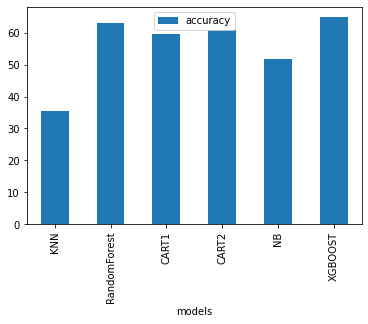

In [120]:
plt.figure(figsize=(18, 6))
accdf.plot(x='models',y='accuracy',kind='bar')

#RFE

In [127]:
j=df.columns[:-1]

In [128]:
from sklearn.feature_selection import RFE
acc=[]
for z in range(1,29):
  model = RandomForestClassifier(n_estimators = 2*z, criterion = 'gini',random_state=30)
  rfe = RFE(model,n_features_to_select=z,step=1)
  fitter = rfe.fit(X, y)
  k=fitter.support_
  m=[]
  for i in range(len(j)):
    if k[i]==True:
      m.append(j[i])
  X1=df[m].iloc[:, :].values
  y1=df.iloc[:, -1].values
  X_train1, X_test1, y_train1, y_test1 = train_test_split(X1, y1, test_size = 0.15)
  logreg=model.fit(X_train1,y_train1)
  y_pred1 = logreg.predict(X_test1)
  cm1 = confusion_matrix(y_test1, y_pred1)
  #print(cm1)
  acc.append([accuracy_score(y_test1, y_pred1),z])

In [129]:
acc

[[0.21974041654089949, 1],
 [0.43072743736794444, 2],
 [0.41472985209779656, 3],
 [0.42438877150618776, 4],
 [0.42167220042257775, 5],
 [0.41050407485662543, 6],
 [0.4056746151524298, 7],
 [0.41563537579233323, 8],
 [0.4412918804708723, 9],
 [0.4470268638696046, 10],
 [0.49230304859643825, 11],
 [0.5258074252942952, 12],
 [0.5028674916993662, 13],
 [0.5288258376094175, 14],
 [0.5415031693329309, 15],
 [0.5167521883489284, 16],
 [0.568668880169031, 17],
 [0.5620283730757621, 18],
 [0.5722909749471777, 19],
 [0.5707817687896166, 20],
 [0.5795351645034712, 21],
 [0.6067008753395714, 22],
 [0.6000603682463025, 23],
 [0.5946272260790824, 24],
 [0.6027769393299125, 25],
 [0.6281316027769394, 26],
 [0.6314518563235738, 27],
 [0.6326592212496227, 28]]